In [18]:
import os
import matplotlib.image as mpimg


label_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels"

file_label_counts = []

for file in os.listdir(label_dir):
    if file.endswith(".txt"):
        file_path = os.path.join(label_dir, file)
        with open(file_path, 'r') as f:
            num_labels = sum(1 for line in f if line.strip())
            file_label_counts.append((file, num_labels))

# Sort files by number of labels in descending order
file_label_counts.sort(key=lambda x: x[1], reverse=True)

# Print top 10
for i, (filename, count) in enumerate(file_label_counts[:10], 1):
    print(f"{i}. {filename}: {count} labels")


1. 27.7644_77.7249.txt: 22 labels
2. 27.7644_77.7283.txt: 20 labels
3. 24.0172_89.0908.txt: 17 labels
4. 25.6628_84.9646.txt: 16 labels
5. 25.6628_84.9613.txt: 14 labels
6. 25.1556_82.9985.txt: 13 labels
7. 25.6540_84.9437.txt: 13 labels
8. 22.6415_88.9254.txt: 13 labels
9. 24.0997_90.3408.txt: 12 labels
10. 23.7997_90.3144.txt: 12 labels


In [95]:
import os
import shutil

# Paths
label_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels"
image_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images"
output_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/most_labels"

# Create output directory if needed
os.makedirs(output_dir, exist_ok=True)

# Collect and count labels
file_label_counts = []
for file in os.listdir(label_dir):
    if file.endswith(".txt"):
        file_path = os.path.join(label_dir, file)
        with open(file_path, 'r') as f:
            num_labels = sum(1 for line in f if line.strip())
            file_label_counts.append((file, num_labels))

# Sort and get top 10
file_label_counts.sort(key=lambda x: x[1], reverse=True)
top_10 = file_label_counts[:60]

# Fetch and copy corresponding images and label files
copied_files = []
for label_file, count in top_10:
    base_name = os.path.splitext(label_file)[0]
    label_src = os.path.join(label_dir, label_file)
    label_dst = os.path.join(output_dir, label_file)

    # Copy label file
    shutil.copy(label_src, label_dst)

    # Try different image extensions
    for ext in ['.png', '.jpg', '.jpeg', '.tif']:
        image_path = os.path.join(image_dir, base_name + ext)
        if os.path.exists(image_path):
            shutil.copy(image_path, os.path.join(output_dir, base_name + ext))
            copied_files.append((label_file, os.path.basename(image_path)))
            break

# Print summary
print("Top 10 label files and corresponding images copied:")
for i, (label_file, image_name) in enumerate(copied_files, 1):
    print(f"{i}. {label_file} → {image_name}")


Top 10 label files and corresponding images copied:
1. 27.7644_77.7249.txt → 27.7644_77.7249.png
2. 27.7644_77.7283.txt → 27.7644_77.7283.png
3. 24.0172_89.0908.txt → 24.0172_89.0908.png
4. 25.6628_84.9646.txt → 25.6628_84.9646.png
5. 25.6628_84.9613.txt → 25.6628_84.9613.png
6. 25.1556_82.9985.txt → 25.1556_82.9985.png
7. 25.6540_84.9437.txt → 25.6540_84.9437.png
8. 22.6415_88.9254.txt → 22.6415_88.9254.png
9. 24.0997_90.3408.txt → 24.0997_90.3408.png
10. 23.7997_90.3144.txt → 23.7997_90.3144.png
11. 23.7415_86.9931.txt → 23.7415_86.9931.png
12. 23.6261_89.8530.txt → 23.6261_89.8530.png
13. 33.5838_72.9061.txt → 33.5838_72.9061.png
14. 22.6118_88.5843.txt → 22.6118_88.5843.png
15. 22.6151_88.5843.txt → 22.6151_88.5843.png
16. 33.9011_71.6312.txt → 33.9011_71.6312.png
17. 23.6261_90.4408.txt → 23.6261_90.4408.png
18. 24.7715_84.3146.txt → 24.7715_84.3146.png
19. 33.8978_71.6312.txt → 33.8978_71.6312.png
20. 25.8467_80.6397.txt → 25.8467_80.6397.png
21. 22.5761_92.0529.txt → 22.5761_92.

In [96]:
from shapely.geometry import Point, Polygon


In [97]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Polygon, Rectangle

def display_image(file_name, directory_path, directory_path_labels=None, save_path=None, sentinel=True, obb=False):
    img_path = os.path.join(directory_path, file_name)
    print(img_path)
    img = mpimg.imread(img_path)
    fig, ax = plt.subplots(figsize=(6, 6))

    # Class color map
    color_map = {
        0: {'edge': '#8B0000', 'fill': '#FFC0CB'},  # Deep Red + Light Red
        1: {'edge': '#00008B', 'fill': '#ADD8E6'},  # Deep Blue + Light Blue
        2: {'edge': '#006400', 'fill': '#90EE90'},  # Deep Green + Light Green
    }

    if directory_path_labels:
        label_path = os.path.join(directory_path_labels, file_name[:-4] + '.txt')
        print(label_path)
        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                lines = file.readlines()

            for line in lines:
                cor = np.fromstring(line.strip(), sep=' ')
                class_id = int(cor[0])
                colors = color_map.get(class_id, {'edge': 'white', 'fill': 'gray'})

                if not obb:
                    rect_x = cor[1] * img.shape[1]
                    rect_y = cor[2] * img.shape[0]
                    width = cor[3] * img.shape[1]
                    height = cor[4] * img.shape[0]

                    top_left_x = rect_x - width / 2
                    top_left_y = rect_y - height / 2
                    rect = Rectangle(
                        (top_left_x, top_left_y), width, height,
                        linewidth=1, edgecolor=colors['edge'], facecolor=colors['fill'], alpha=0.5
                    )
                    ax.add_patch(rect)
                else:
                    # Extract and scale polygon corners
                    rect_x = cor[1] * img.shape[1]
                    rect_y = cor[2] * img.shape[0]
                    corners = cor[1:].reshape(4, 2)

                    corners[:, 0] *= img.shape[1]
                    corners[:, 1] *= img.shape[0]

                    polygon = Polygon(
                        corners,
                        linewidth=1.5,
                        edgecolor=colors['edge'],
                        facecolor='none',  # Changed 'none' to 'none' (string)
                        alpha=1
                    )
                    ax.add_patch(polygon)
                    center_x = np.mean(corners[:, 0])
                    center_y = np.mean(corners[:, 1])
                    ax.scatter([center_x], [center_y], color=colors['edge'], s=10, zorder=10)

    ax.axis('off')
    ax.imshow(img)
    # format_axes(ax)

    if save_path:
        if sentinel==False:
            if directory_path_labels:
                if obb:
                    combined_plot_path = os.path.join(save_path, f'{file_name[:-4]}_obb.pdf')
                    plt.savefig(combined_plot_path, format='pdf', bbox_inches='tight', pad_inches=0,dpi=600) 
                else:   
                    combined_plot_path = os.path.join(save_path, f'{file_name[:-4]}_box.pdf')
                    plt.savefig(combined_plot_path, format='pdf', bbox_inches='tight',pad_inches=0, dpi=600)
            else:
                combined_plot_path = os.path.join(save_path, f'{file_name[:-4]}.pdf')
                plt.savefig(combined_plot_path, format='pdf', bbox_inches='tight',pad_inches=0, dpi=600,)
        else:
            if directory_path_labels:  
                if obb:
                    combined_plot_path = os.path.join(save_path, f'{file_name[:-4]}_sen_obb.pdf')
                    plt.savefig(combined_plot_path, format='pdf', bbox_inches='tight',pad_inches=0, dpi=600)  
                else:
                    combined_plot_path = os.path.join(save_path, f'{file_name[:-4]}_sen_box.pdf')
                    plt.savefig(combined_plot_path, format='pdf', bbox_inches='tight',pad_inches=0, dpi=600)
            else:
                combined_plot_path = os.path.join(save_path, f'{file_name[:-4]}_sen.pdf')
                plt.savefig(combined_plot_path, format='pdf', bbox_inches='tight', pad_inches=0, dpi=600)

    plt.show()
    plt.close(fig)


Processing: 28.9293_76.9146.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/28.9293_76.9146.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/28.9293_76.9146.txt


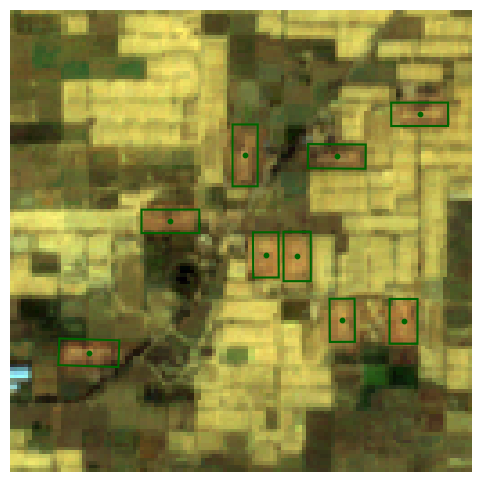

Processing: 26.8555_80.3283.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/26.8555_80.3283.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/26.8555_80.3283.txt


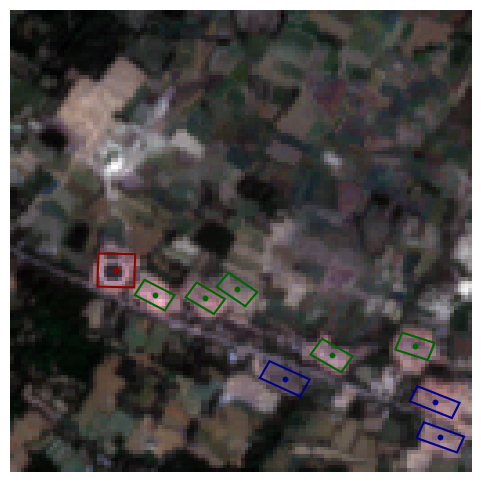

Processing: 22.6239_88.6019.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/22.6239_88.6019.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/22.6239_88.6019.txt


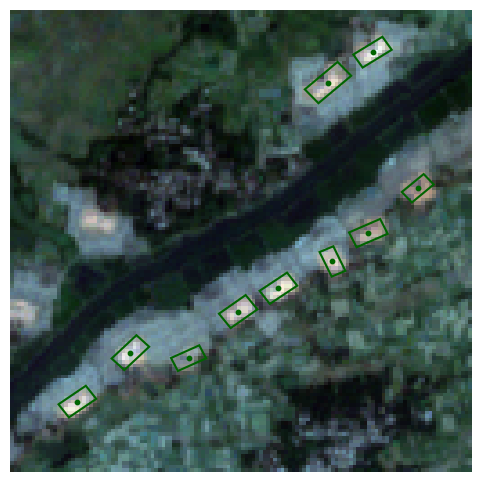

Processing: 23.6261_89.8496.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/23.6261_89.8496.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/23.6261_89.8496.txt


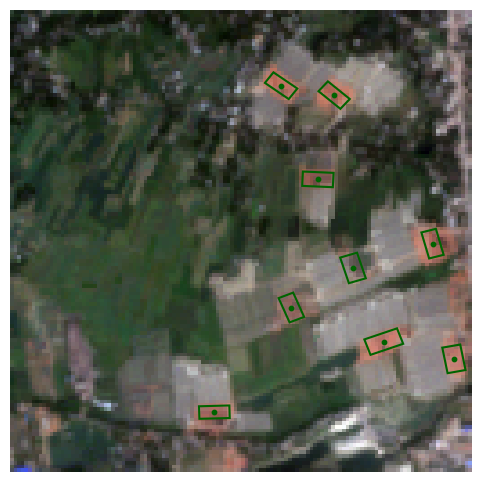

Processing: 30.4978_76.8620.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/30.4978_76.8620.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/30.4978_76.8620.txt


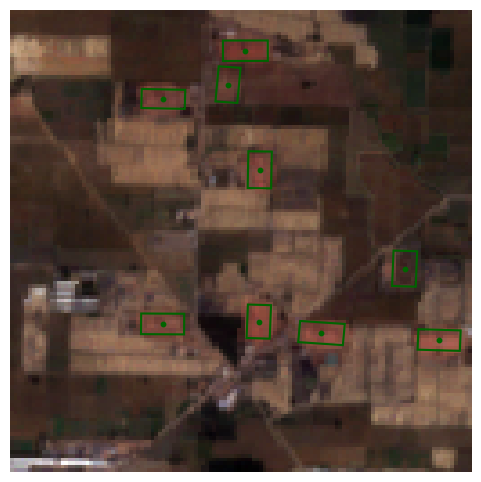

Processing: 22.6151_88.5931.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/22.6151_88.5931.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/22.6151_88.5931.txt


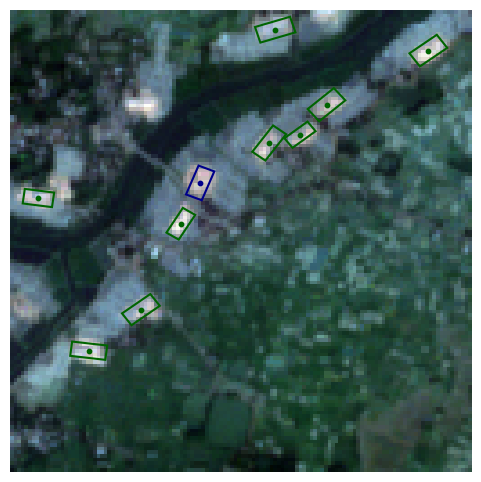

Processing: 22.6004_88.5755.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/22.6004_88.5755.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/22.6004_88.5755.txt


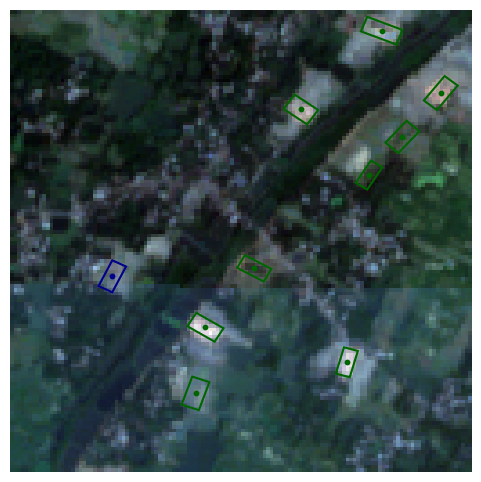

Processing: 27.9643_77.4485.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/27.9643_77.4485.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/27.9643_77.4485.txt


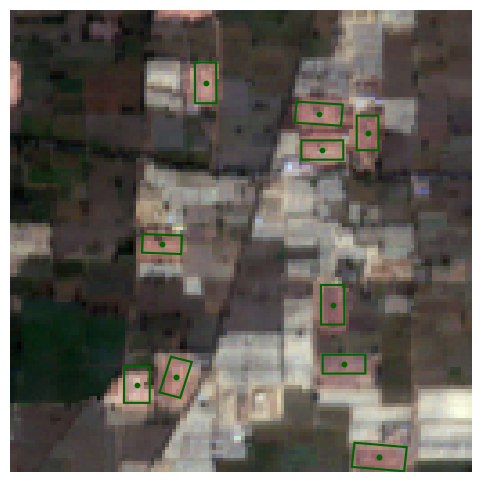

Processing: 25.6628_84.9613.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/25.6628_84.9613.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/25.6628_84.9613.txt


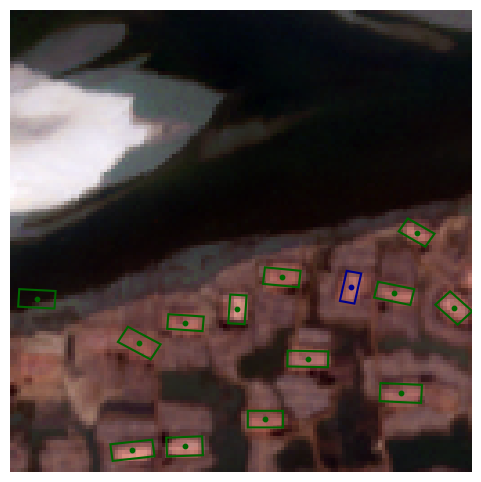

Processing: 23.7415_86.9931.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/23.7415_86.9931.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/23.7415_86.9931.txt


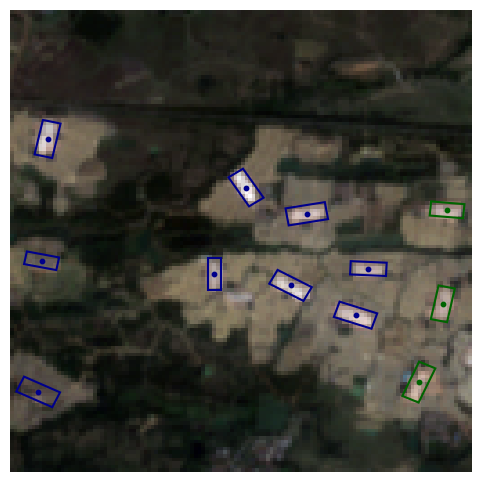

Processing: 31.7426_73.9675.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/31.7426_73.9675.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/31.7426_73.9675.txt


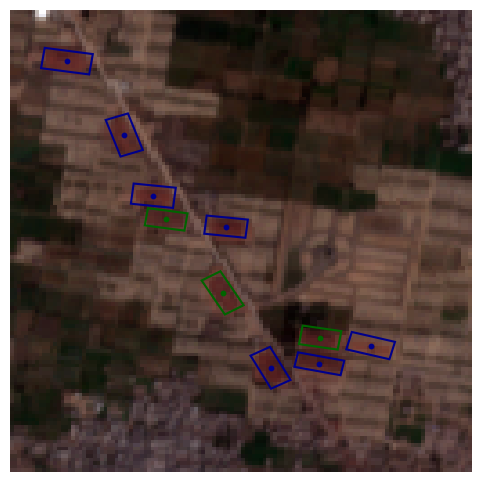

Processing: 22.4915_88.7754.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/22.4915_88.7754.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/22.4915_88.7754.txt


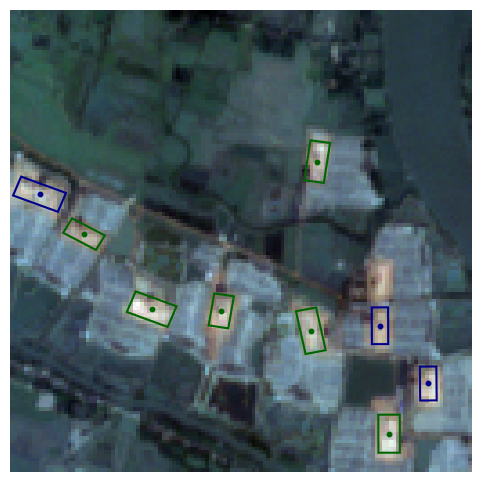

Processing: 23.6496_90.5496.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/23.6496_90.5496.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/23.6496_90.5496.txt


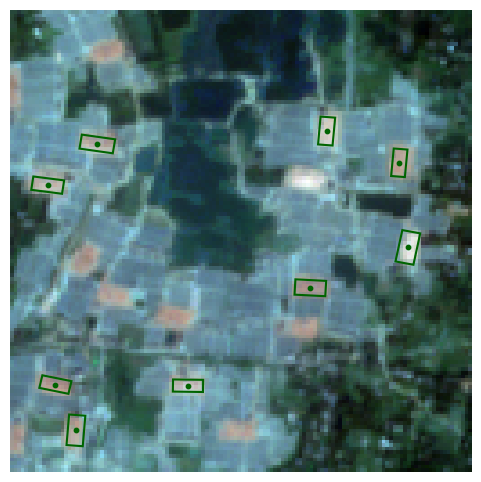

Processing: 22.6151_88.5843.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/22.6151_88.5843.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/22.6151_88.5843.txt


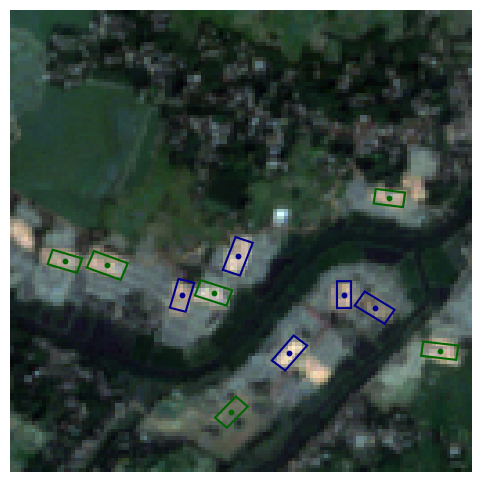

Processing: 31.2041_74.3028.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/31.2041_74.3028.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/31.2041_74.3028.txt


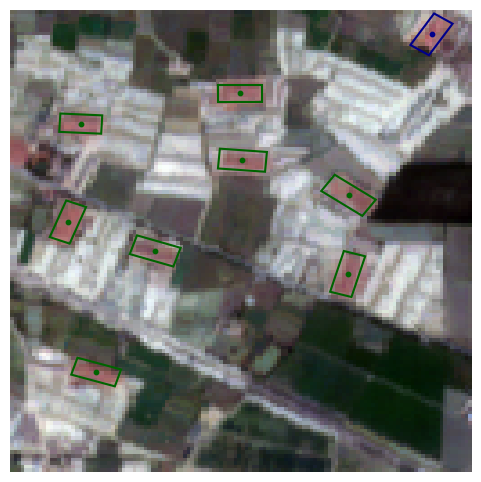

Processing: 23.6740_87.1431.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/23.6740_87.1431.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/23.6740_87.1431.txt


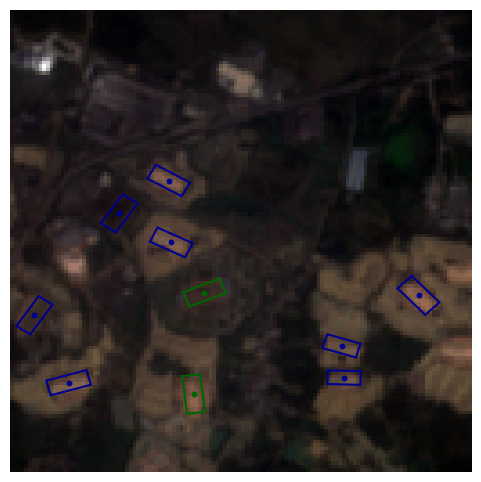

Processing: 25.4128_86.0024.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/25.4128_86.0024.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/25.4128_86.0024.txt


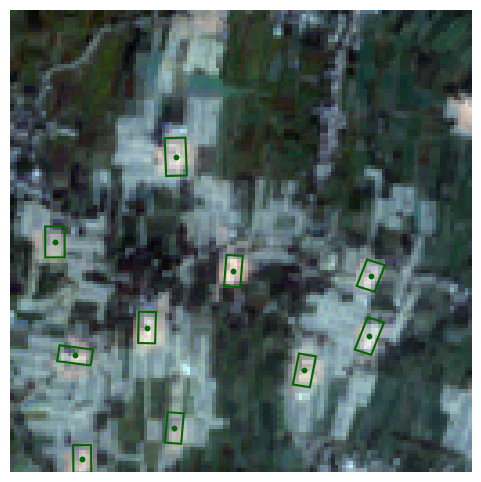

Processing: 22.5761_92.0529.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/22.5761_92.0529.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/22.5761_92.0529.txt


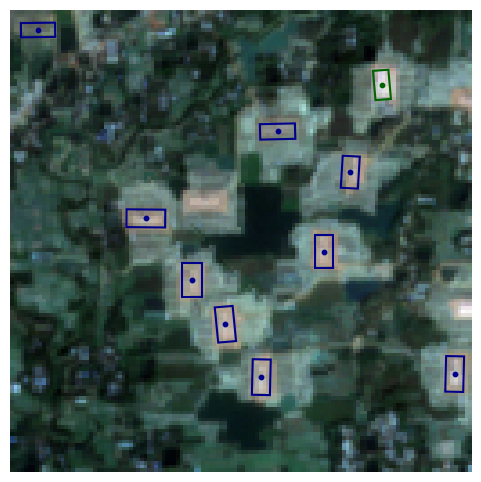

Processing: 28.6617_76.6970.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/28.6617_76.6970.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/28.6617_76.6970.txt


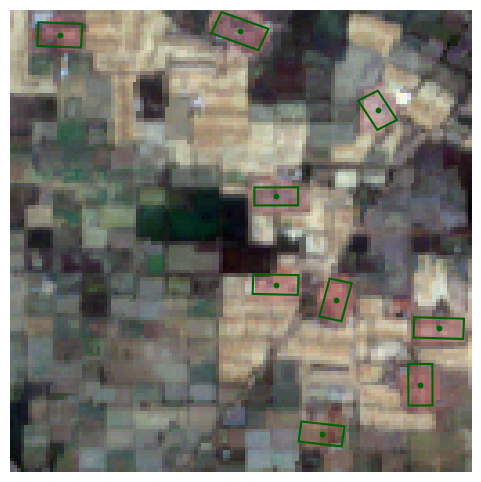

Processing: 22.5849_92.0529.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/22.5849_92.0529.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/22.5849_92.0529.txt


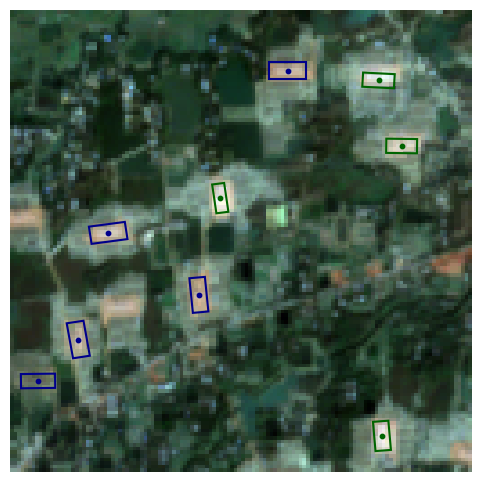

Processing: 23.6261_90.4408.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/23.6261_90.4408.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/23.6261_90.4408.txt


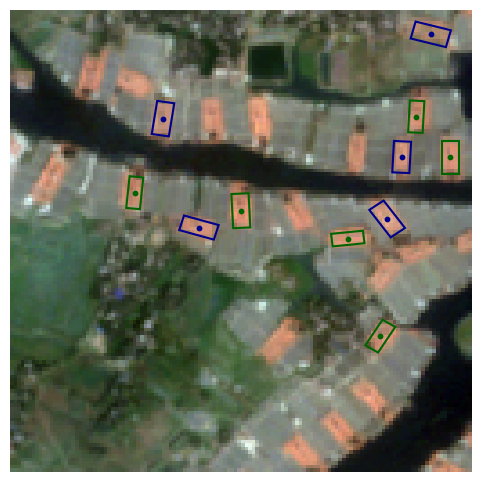

Processing: 24.7760_89.4030.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/24.7760_89.4030.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/24.7760_89.4030.txt


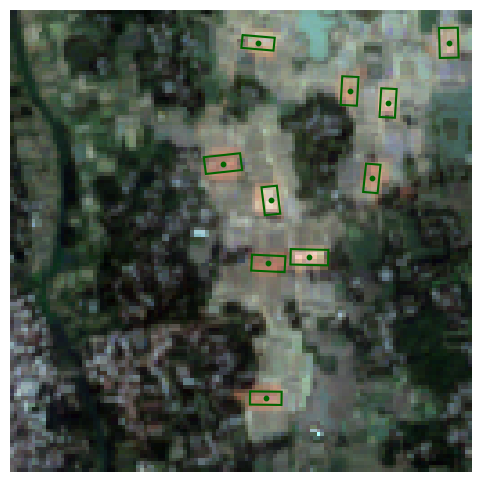

Processing: 27.3555_81.7783.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/27.3555_81.7783.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/27.3555_81.7783.txt


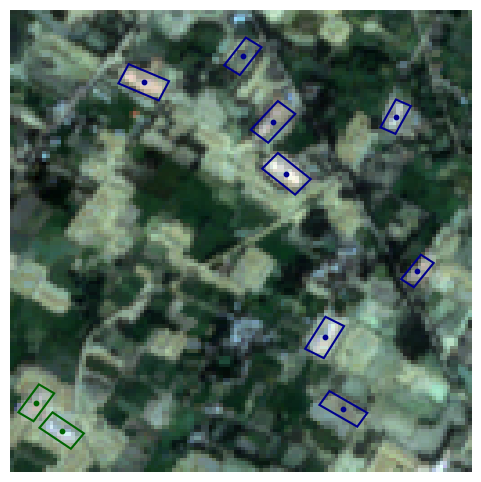

Processing: 23.6261_89.8530.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/23.6261_89.8530.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/23.6261_89.8530.txt


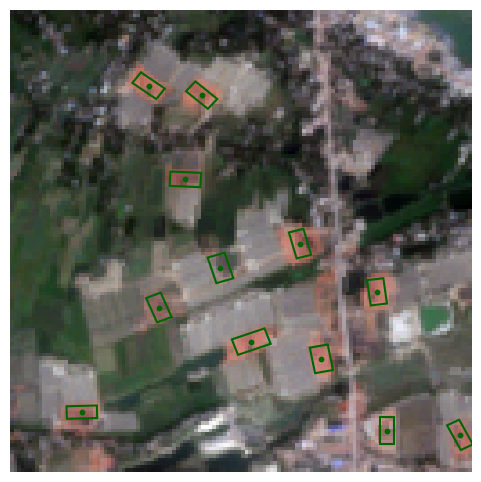

Processing: 33.5838_72.9061.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/33.5838_72.9061.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/33.5838_72.9061.txt


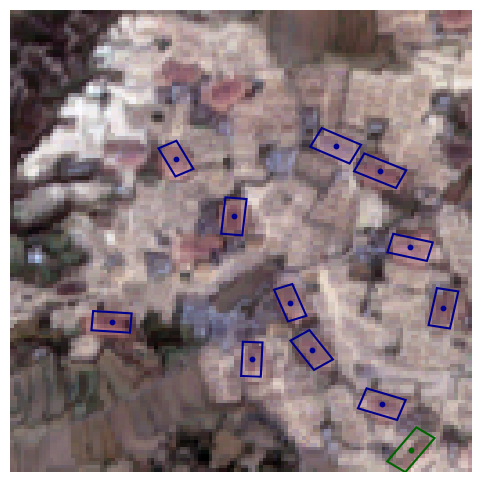

Processing: 25.1556_82.9985.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/25.1556_82.9985.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/25.1556_82.9985.txt


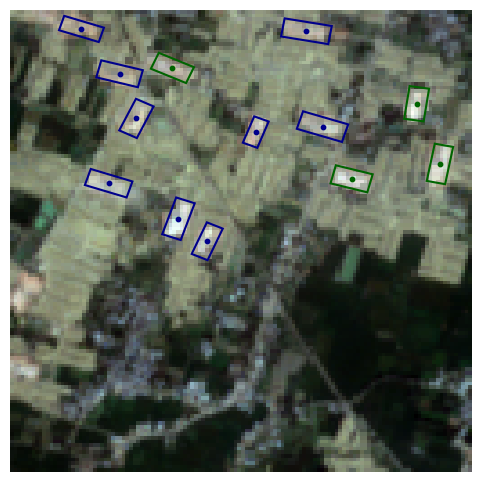

Processing: 28.6055_78.5249.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/28.6055_78.5249.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/28.6055_78.5249.txt


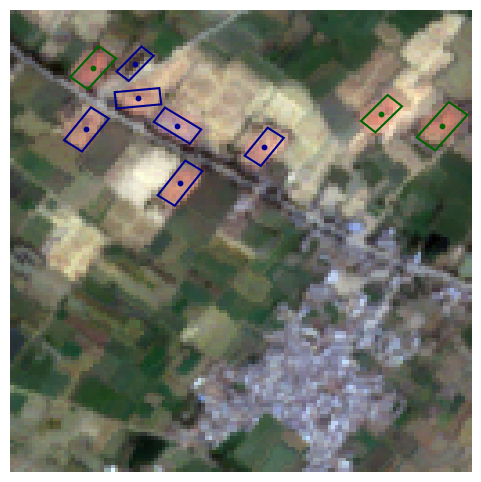

Processing: 25.1791_82.9985.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/25.1791_82.9985.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/25.1791_82.9985.txt


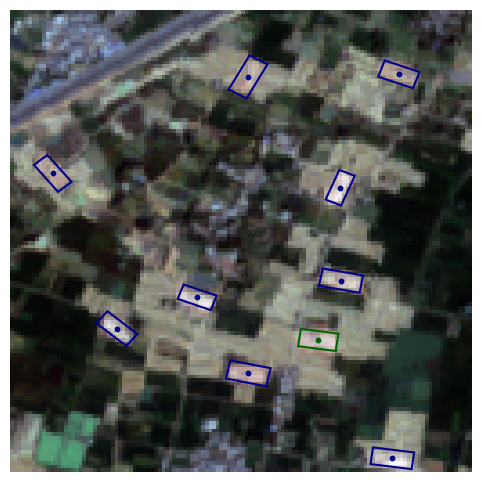

Processing: 24.0172_89.0908.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/24.0172_89.0908.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/24.0172_89.0908.txt


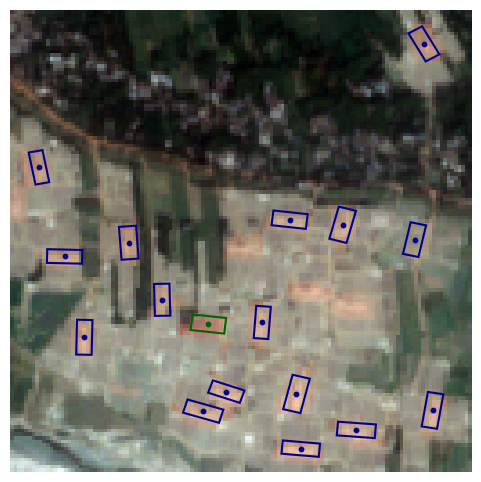

Processing: 32.9540_72.9263.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/32.9540_72.9263.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/32.9540_72.9263.txt


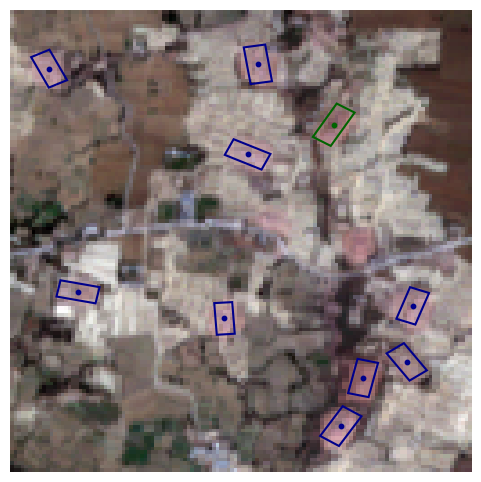

Processing: 22.6118_88.5843.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/22.6118_88.5843.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/22.6118_88.5843.txt


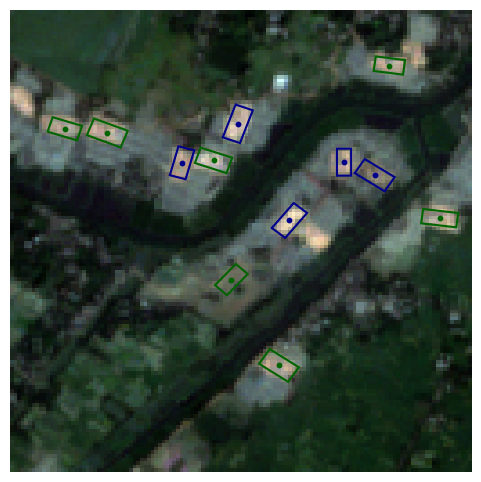

Processing: 27.9143_80.8249.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/27.9143_80.8249.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/27.9143_80.8249.txt


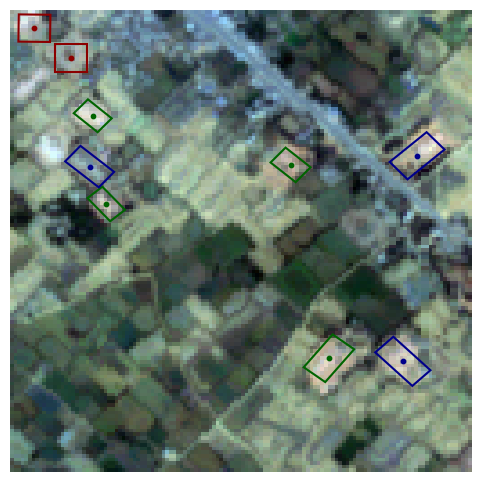

Processing: 27.7644_78.6249.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/27.7644_78.6249.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/27.7644_78.6249.txt


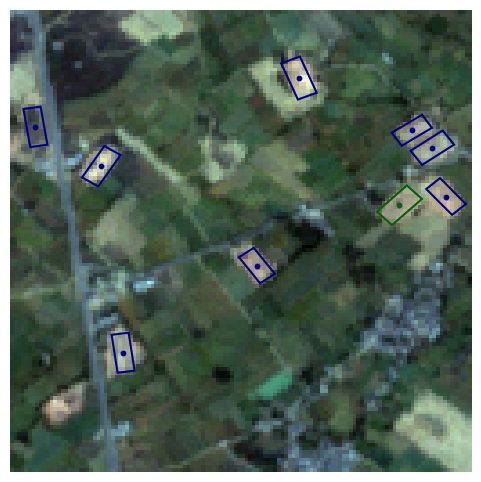

Processing: 24.0997_90.3408.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/24.0997_90.3408.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/24.0997_90.3408.txt


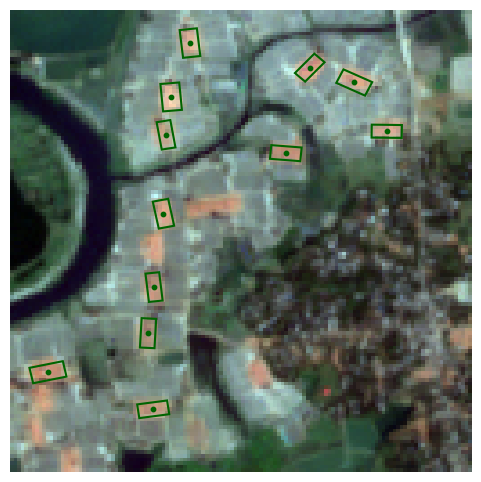

Processing: 25.8467_80.6283.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/25.8467_80.6283.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/25.8467_80.6283.txt


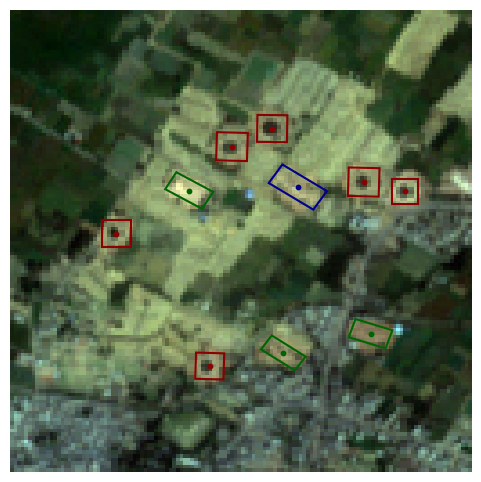

Processing: 27.8791_78.3283.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/27.8791_78.3283.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/27.8791_78.3283.txt


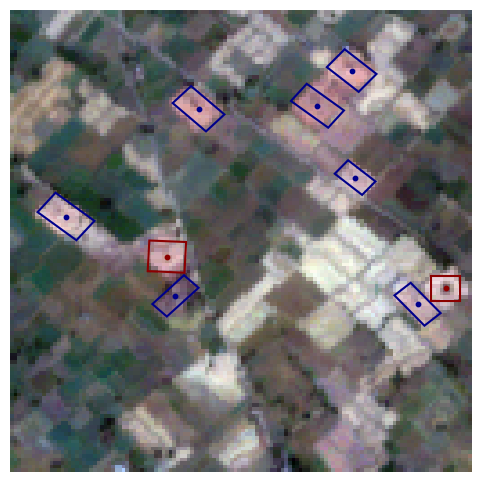

Processing: 24.9039_85.0024.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/24.9039_85.0024.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/24.9039_85.0024.txt


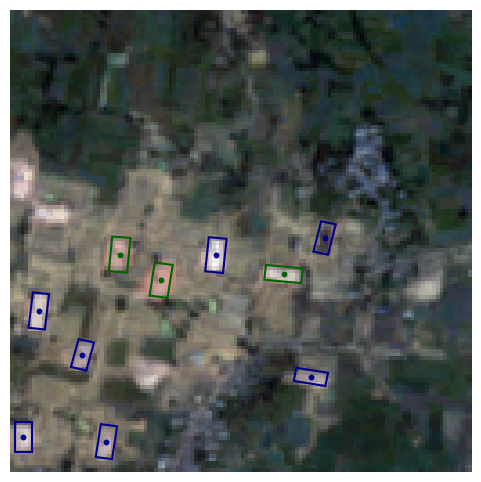

Processing: 29.3467_77.3250.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/29.3467_77.3250.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/29.3467_77.3250.txt


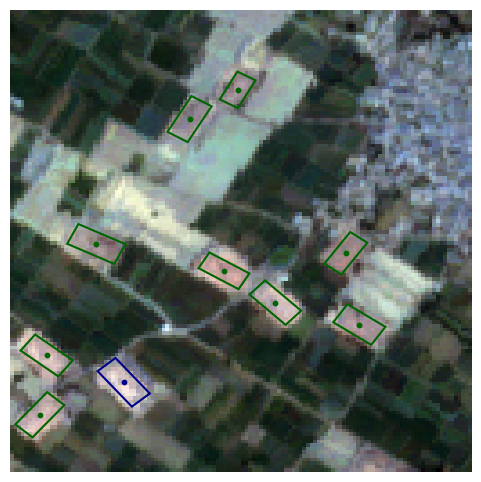

Processing: 25.8467_80.6397.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/25.8467_80.6397.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/25.8467_80.6397.txt


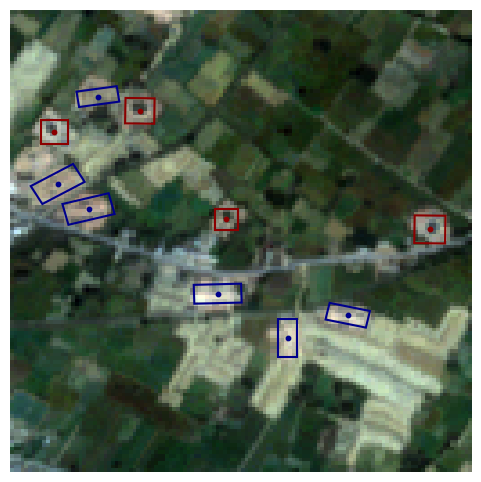

Processing: 27.3643_81.7783.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/27.3643_81.7783.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/27.3643_81.7783.txt


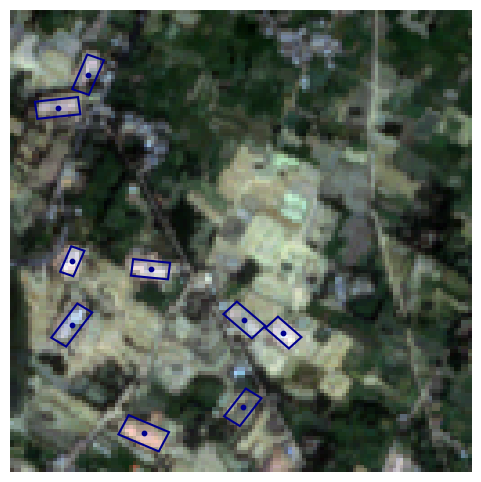

Processing: 27.7644_77.7249.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/27.7644_77.7249.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/27.7644_77.7249.txt


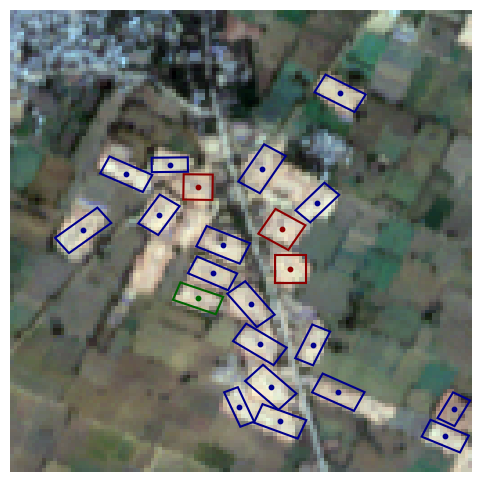

Processing: 25.6540_84.9437.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/25.6540_84.9437.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/25.6540_84.9437.txt


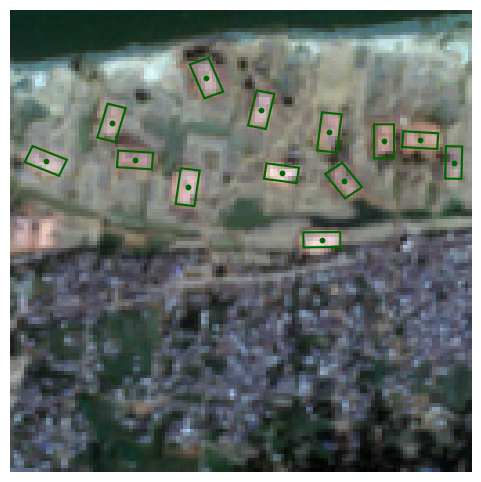

Processing: 26.9170_78.1402.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/26.9170_78.1402.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/26.9170_78.1402.txt


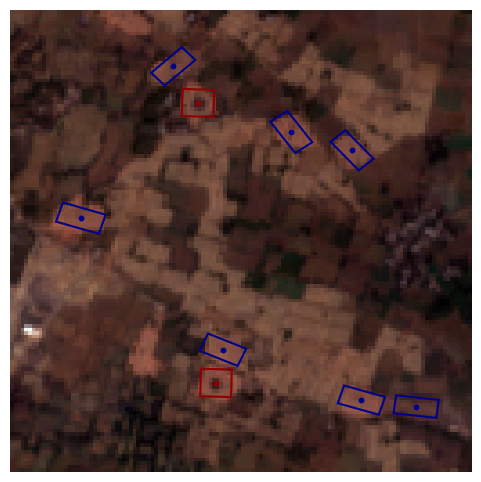

Processing: 27.7644_77.7283.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/27.7644_77.7283.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/27.7644_77.7283.txt


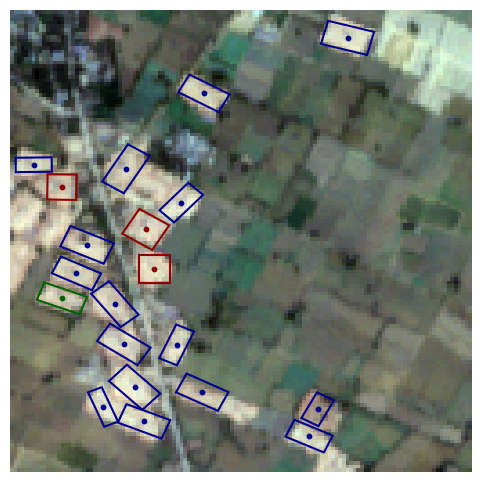

Processing: 28.7556_77.4397.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/28.7556_77.4397.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/28.7556_77.4397.txt


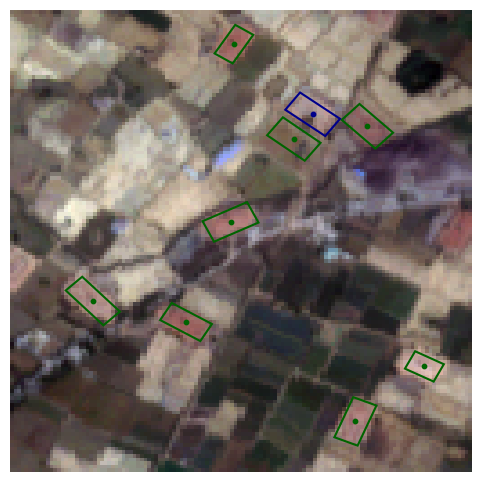

Processing: 23.7962_90.3144.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/23.7962_90.3144.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/23.7962_90.3144.txt


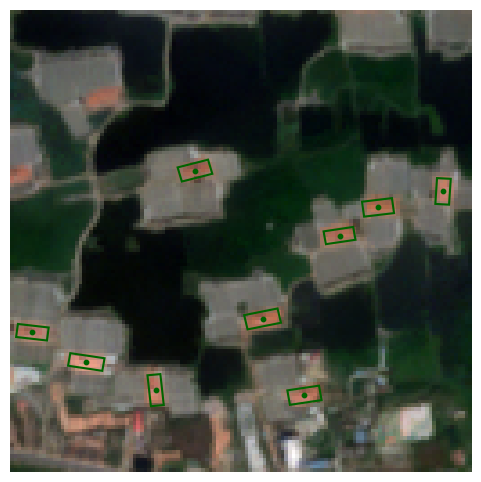

Processing: 32.2541_74.1851.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/32.2541_74.1851.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/32.2541_74.1851.txt


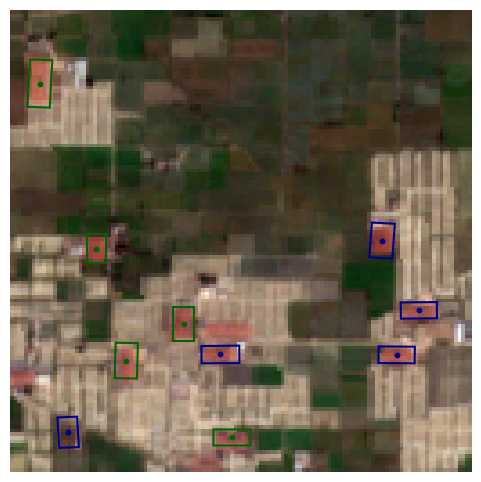

Processing: 33.8978_71.6312.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/33.8978_71.6312.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/33.8978_71.6312.txt


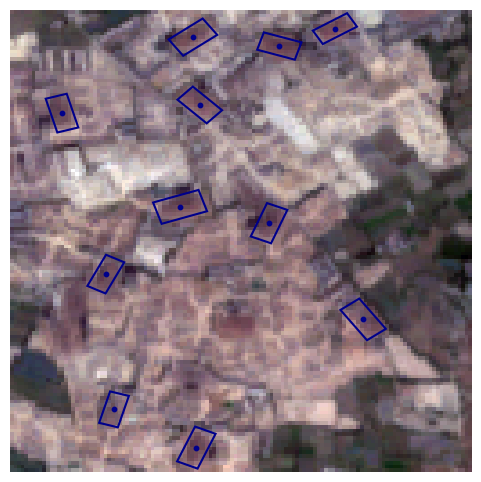

Processing: 28.5967_78.5397.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/28.5967_78.5397.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/28.5967_78.5397.txt


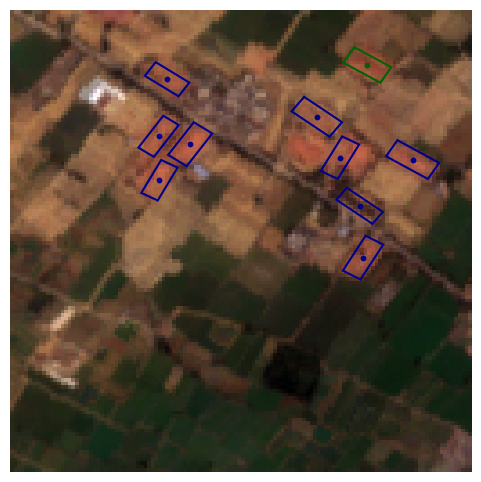

Processing: 27.3643_81.7749.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/27.3643_81.7749.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/27.3643_81.7749.txt


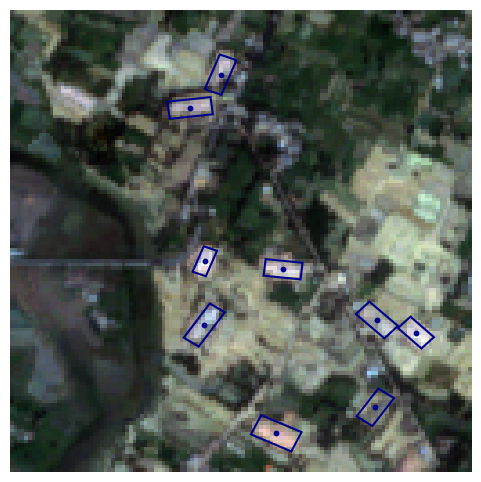

Processing: 27.7791_77.7283.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/27.7791_77.7283.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/27.7791_77.7283.txt


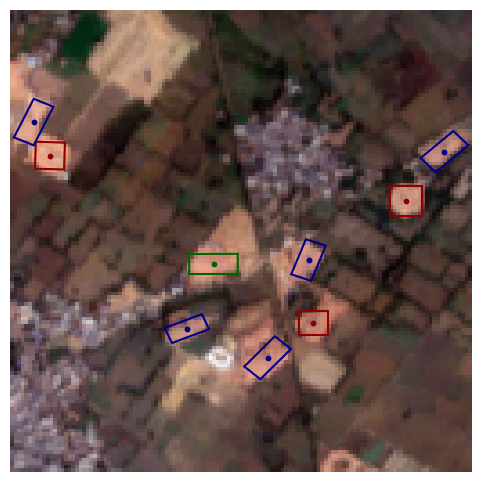

Processing: 26.1967_79.8283.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/26.1967_79.8283.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/26.1967_79.8283.txt


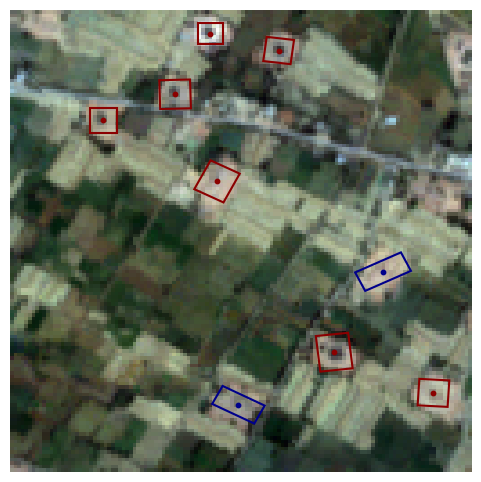

Processing: 23.7997_90.3144.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/23.7997_90.3144.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/23.7997_90.3144.txt


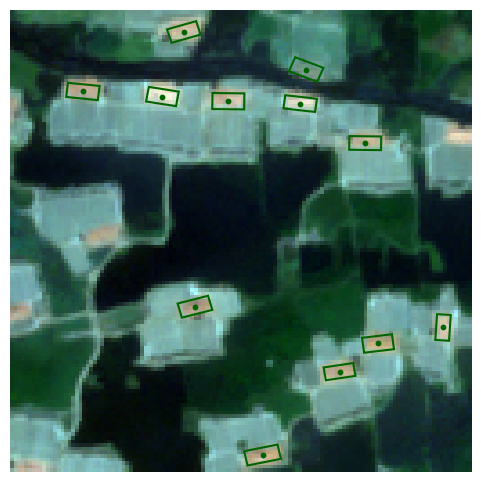

Processing: 25.6628_84.9646.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/25.6628_84.9646.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/25.6628_84.9646.txt


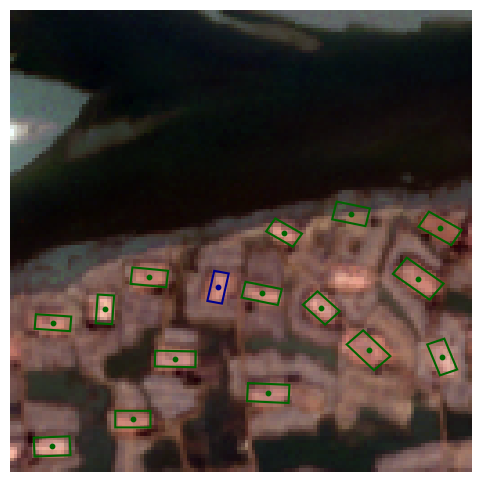

Processing: 33.9600_71.8548.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/33.9600_71.8548.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/33.9600_71.8548.txt


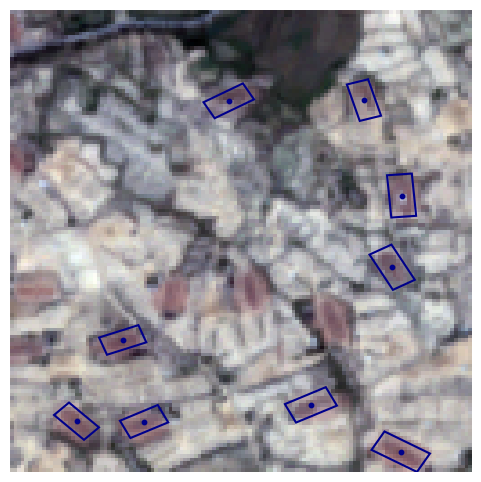

Processing: 25.4918_85.7260.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/25.4918_85.7260.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/25.4918_85.7260.txt


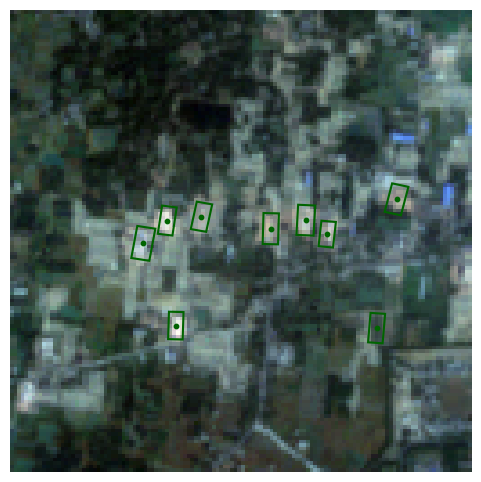

Processing: 33.9011_71.6312.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/33.9011_71.6312.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/33.9011_71.6312.txt


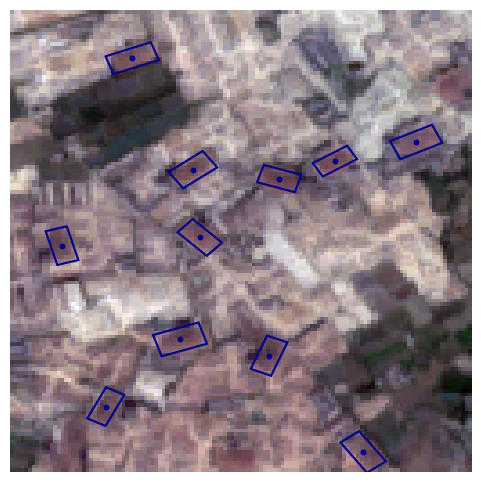

Processing: 25.1644_82.9985.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/25.1644_82.9985.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/25.1644_82.9985.txt


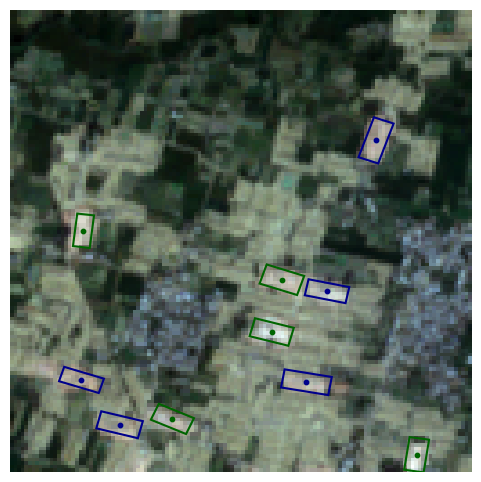

Processing: 24.7715_84.3146.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/24.7715_84.3146.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/24.7715_84.3146.txt


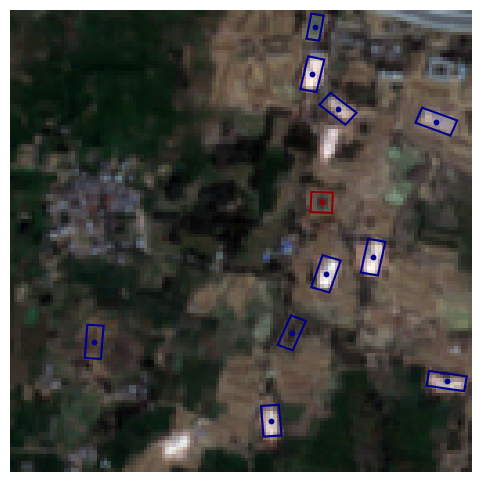

Processing: 22.6415_88.9254.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images/22.6415_88.9254.png
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels/22.6415_88.9254.txt


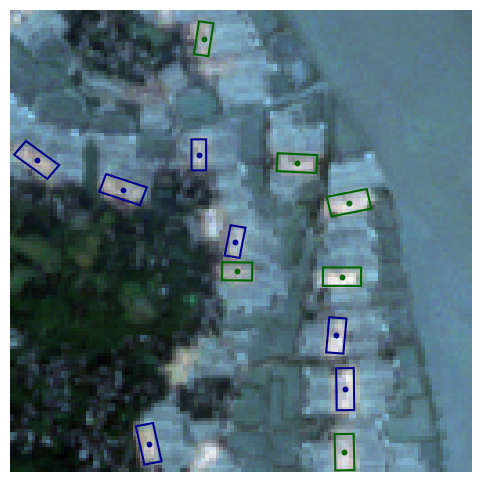

In [98]:
# ======= RUN ON ALL IMAGES IN THE DIRECTORY =======

most_labels_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/most_labels"
image_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/images"
label_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/labels"
save_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/brick_kilns_neurips_2025/figures"

# Process all image files
for file_name in os.listdir(most_labels_dir):
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):
        print(f"Processing: {file_name}")
        display_image(
            file_name=file_name,
            directory_path=image_dir,
            directory_path_labels=label_dir,
            save_path=save_dir,
            sentinel=False,
            obb=True
        )